In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
import numpy as np

import os
from matplotlib import pyplot as plt
%matplotlib inline
from create_foreground_background import fg_bg_data,fg_data
from mini_inception import inception_net
from resnet import ResNet18,ResNet34,ResNet50

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [ ]:
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)


# fg vs bg classification
trainset.targets = fg_bg_data(trainset.targets,[0,1,2])
testset.targets = fg_bg_data(testset.targets,[0,1,2])

# Fg classification
# train_data,train_labels = fg_data(trainset.data,trainset.targets,[0,1,2])
# test_data,test_labels = fg_data(testset.data,testset.targets,[0,1,2])
# trainset.data = train_data
# trainset.targets = train_labels

# testset.data = test_data
# testset.targets = test_labels

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat', 'deer',
#            'dog', 'frog', 'horse', 'ship', 'truck')
classes = ('foreground','background')

In [ ]:
#net = inception_net(3,3)
net = ResNet34(3)
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)

In [ ]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'% (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    return train_loss/(batch_idx+1)

In [ ]:
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc
    return test_loss/(batch_idx+1)


In [ ]:
best_acc = 0 
start_epoch =0
tr_loss = []
ts_loss = []
for epoch in range(start_epoch, start_epoch+50):
    tr_loss.append(train(epoch))
    ts_loss.append(test(epoch))


Epoch: 0
390 391 Loss: 0.530 | Acc: 74.584% (37292/50000)
99 100 Loss: 0.486 | Acc: 79.420% (7942/10000)
Saving..

Epoch: 1
390 391 Loss: 0.396 | Acc: 82.642% (41321/50000)
99 100 Loss: 0.447 | Acc: 78.700% (7870/10000)

Epoch: 2
390 391 Loss: 0.323 | Acc: 86.686% (43343/50000)
99 100 Loss: 0.332 | Acc: 85.500% (8550/10000)
Saving..

Epoch: 3
390 391 Loss: 0.266 | Acc: 89.054% (44527/50000)
99 100 Loss: 0.295 | Acc: 88.350% (8835/10000)
Saving..

Epoch: 4
390 391 Loss: 0.221 | Acc: 91.128% (45564/50000)
99 100 Loss: 0.372 | Acc: 83.740% (8374/10000)

Epoch: 5
390 391 Loss: 0.183 | Acc: 92.820% (46410/50000)
99 100 Loss: 0.405 | Acc: 87.200% (8720/10000)

Epoch: 6
390 391 Loss: 0.149 | Acc: 94.114% (47057/50000)
99 100 Loss: 0.288 | Acc: 89.660% (8966/10000)
Saving..

Epoch: 7
390 391 Loss: 0.113 | Acc: 95.674% (47837/50000)
99 100 Loss: 0.320 | Acc: 88.840% (8884/10000)

Epoch: 8
390 391 Loss: 0.093 | Acc: 96.556% (48278/50000)
99 100 Loss: 0.543 | Acc: 83.250% (8325/10000)

Epoch: 9


In [ ]:
model = ResNet34(3)
#model = inception_net(3,3)
model = model.to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True


checkpoint = torch.load('./checkpoint/ckpt.pth')
model.load_state_dict(checkpoint['net'])


epoch = checkpoint['epoch']
test_acc = checkpoint['acc']

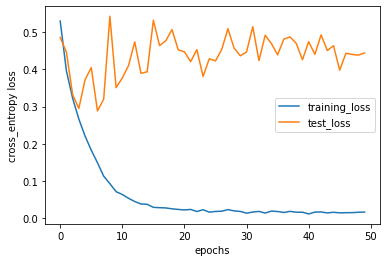

In [ ]:
plt.plot(tr_loss,label='training_loss')
plt.plot(ts_loss,label = 'test_loss')
plt.xlabel("epochs")
plt.ylabel("cross_entropy loss")
plt.legend()

In [ ]:
test_acc

91.27